# NLP Mark Manson

In this repo I have scraped all of the articles on Mark Manson's website and performed analysis on it.   

The scrapers can be seen in [scrape_articles.py](../scraper/scrape_articles.py).   

In [1]:
import string
import re
import sys

import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from wordcloud import WordCloud

import datetime

import sqlite3
import numpy as np
import pandas as pd

import Summarizer_HuggingFace
import LatentDirichletAllocation_Gensim

# $ pip install nltk
# $ python
# >> nltk.download('stopwords')
# >> nltk.download('punkt')
# >> nltk.download('wordnet')
# >> nltk.download('omw-1.4')
# >> nltk.download('averaged_perceptron_tagger')
# >> nltk.download('universal_tagset')
# quit()
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

DATABASE_NAME="../data/articles.db"

/Users/michaelhammer/Documents/Coding_Projects/NLPMarkManson/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Declaring some functions for later.

In [2]:
def get_file_text(filepath, line_divider=" "):
    '''
    This function joins all the lines into a single string and removes any newlines
    '''
    lines = []
    with open(filepath) as f:
        lines = f.readlines()
    return "{}".format(line_divider).join(lines).replace("\n", " ")

def get_num_words(text):
    word_tokens = word_tokenize(text)

    # remove the punctuation
    punc_list = set(string.punctuation)
    punc_free_words = [w for w in word_tokens if w not in punc_list]
    alphanumeric_words = [w for w in punc_free_words if (w.isalnum())]

    return len(alphanumeric_words)


def clean_text(text):
    # lowercase the words
    lowercase_text = text.lower()
    
    # convert text into a list of words (tokens)
    word_tokens = word_tokenize(lowercase_text)

    # Remove Stop Words
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
    stop_free_words = [w for w in word_tokens if w not in stop_words]

    # lemmatize the words
    lemmatizer = WordNetLemmatizer()
    lammatized_words = [lemmatizer.lemmatize(w) for w in stop_free_words]

    # remove the punctuation
    punc_list = set(string.punctuation)
    punc_free_words = [w for w in lammatized_words if w not in punc_list]
    alphanumeric_words = [w for w in punc_free_words if (w.isalnum())]

    # Stem the words
    # ps = PorterStemmer()
    # stemmed_words = [ps.stem(w) for w in lammatized_words]

    return " ".join(alphanumeric_words)

In [3]:

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect(DATABASE_NAME)
df = pd.read_sql_query("SELECT * from articles", con, index_col ="name")
con.close()

# Create Text Column
df["text"] = ""
df["tokens"] = ""
df["raw_text"] = ""
df["raw_text_sentences"] = ""
df["num_words"] = ""
long_string_list = []
article_words_list = []
for i, row in df.iterrows():
    filepath = row["filepath"]
    raw_text = get_file_text(filepath)
    raw_text_sentences = get_file_text(filepath, line_divider=" . ")
    cleaned_text = clean_text(raw_text)
    row["raw_text"] = raw_text
    row["raw_text_sentences"] = raw_text_sentences
    row["text"] = cleaned_text
    
    word_tokens = word_tokenize(cleaned_text)
    row["tokens"] = word_tokens
    article_words_list.append(word_tokens)

    long_string_list.append(cleaned_text)

    row["num_words"] = get_num_words(raw_text)


In [4]:
def create_word_cloud(long_string):
    #  Create a WordCloud object
    wordcloud = WordCloud(background_color="white", width=1600, height=800, max_words=200, contour_width=3, contour_color='steelblue')
    
    # Generate a word cloud
    wordcloud.generate(long_string)
    
    # Visualize the word cloud
    plt.figure(figsize = (20,10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

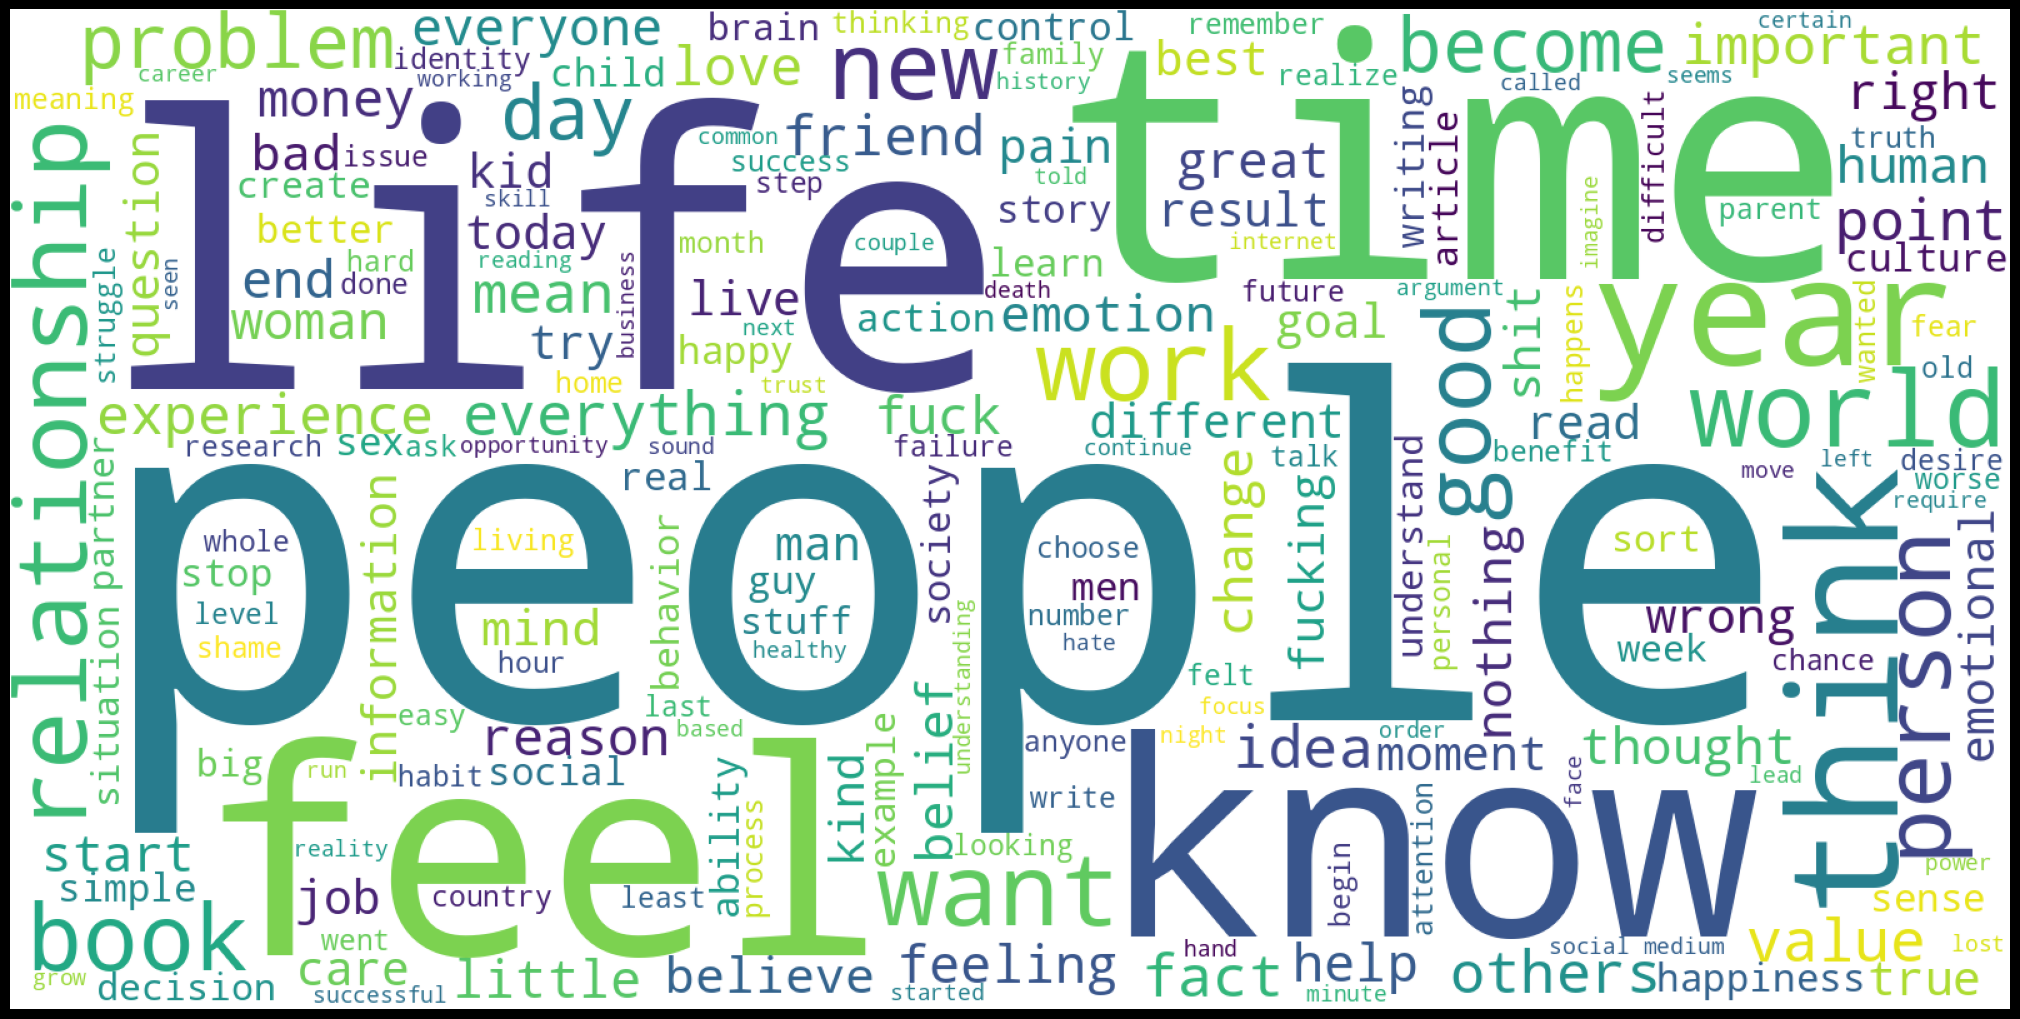

In [5]:

long_string = " ".join(long_string_list)

token_words = long_string.split(" ")
pos_tags = nltk.pos_tag(token_words, tagset='universal')
boring_words = ["much", "got", "u", "take", "going", "yet", "lot", "may", "must", "thing", 
"likely", "could", "let", "able", "often", "well", "see", "give", "really", "way", "even",
 "every", "back", "one", "make", "still", "actually", "come", "something", "rather", "le", 
 "two", "many", "put", "maybe", "say", "said", "far", "keep", "look", "call", "turn", "part",
  "either", "sometime", "pretty", "tell", "seem", "happen", "second", "first", "form", "around", 
  "getting", "go", "might", "place", "another", "sure", "course", "made", "need", "case", "found",
  "find", "cause", "show", "making", "anything", "matter", "someone", "used", "trying", "word", "saying",
  "happening"]
cool_words = []
for i in range(len(token_words)):
    if pos_tags[i][1] in ["NOUN", "VERB", "ADJ"] and pos_tags[i][0] not in boring_words:
        cool_words.append(token_words[i])

long_string = " ".join(cool_words)


create_word_cloud(long_string)


<BarContainer object of 13 artists>

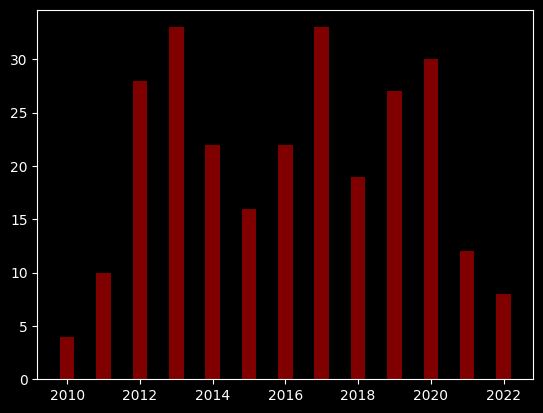

In [6]:
dates_df = pd.to_datetime(df['date'])
years_df = dates_df.dt.year
unique_years = years_df.unique()
num_articles = []
for year in unique_years:
    include = df[dates_df.dt.year == year]
    num_rows = include.shape[0]
    num_articles.append(num_rows)
plt.bar(unique_years, num_articles, color ='maroon',
        width = 0.4)

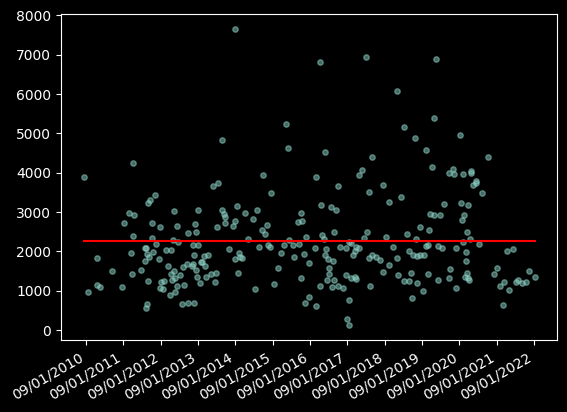

<Figure size 4000x2000 with 0 Axes>

In [7]:
dates_strings = df["date"].to_numpy()
dates = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in dates_strings]
avg_len = sum(df["num_words"]) / len(df["num_words"])
avg_len_points = [avg_len for i in range(len(dates))]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.scatter(dates, df["num_words"], s=15, alpha=0.5)
plt.plot(dates, avg_len_points, color="red")
plt.gcf().autofmt_xdate()
plt.figure(figsize = (40,20), facecolor = None)
plt.tight_layout()
plt.show()

# Topic Modeling (LDA)

In [8]:

lda = LatentDirichletAllocation_Gensim.LatentDirishletAllocation()

num_topics = 6
no_below = 25
no_above = 0.50
id2word_dictionary = lda.create_dictionary(article_words_list, no_below, no_above)
lda.create_bag_of_words_corpus()
# lda_model = lda.create_model(num_topics)
# lda.save_model()
lda_model = lda.load_model()
coherence = lda.get_coherence_score()
print(coherence)


-1.0095429881288538


In [9]:

topics_data = {}
topicid_word_tuples = lda_model.show_topics(num_topics=num_topics, num_words=12, formatted=False)
for topicid_word_tuple in topicid_word_tuples:
    topic_id = topicid_word_tuple[0]
    topic_words_probability_tuples = topicid_word_tuple[1]
    words_list = [w[0] for w in topic_words_probability_tuples]
    words_string = " ".join(words_list)
    print("{}: {}".format(topic_id, words_string))
    topics_data[topic_id] = {
        "topic_words_probability_tuples": topic_words_probability_tuples,
        "clean_words": words_string,
        "words_list": words_list
    }

# After manually looking at the topics and articles
topics_data[0]["Name"] = "World Information - News, Social Media"
topics_data[1]["Name"] = "The Mind - Brain, Reading, Learning, Philosophy"
topics_data[2]["Name"] = "Sex and Dating Women"
topics_data[3]["Name"] = "Resilience Against Life"
topics_data[4]["Name"] = "Pursuit of a Happy Life"
topics_data[5]["Name"] = "Relationship Advice"


0: medium information news attention country health culture today internet read history society
1: belief read philosophy eye page brain trust understanding hope reading question identity
2: woman value men sex goal sexual man culture girl guy young definition
3: emotion shame step hour fucking felt week level stop habit night pain
4: emotion happiness meaning happy decision negative value pain brain control positive bias
5: partner job parent together dating respect question read word healthy yes behavior


In [10]:

df["topic_id"] = ""
for i, row in df.iterrows():
    article_word_tokens = row["tokens"]
    article_bag_of_words = id2word_dictionary.doc2bow(article_word_tokens)
    article_topic_distribution_tuples = lda_model.get_document_topics(article_bag_of_words, per_word_topics=False)
    
    # Get the TopicID that has the greatest probability
    max_tuple = max(article_topic_distribution_tuples, key=lambda x:x[1])
    max_topic_id = max_tuple[0]
    row["topic_id"] = max_topic_id
    
    # Add the file to that topic
    filepath = row["filepath"]
    if "articles" not in topics_data[max_topic_id]:
        topics_data[max_topic_id]["articles"] = []
    topics_data[max_topic_id]["articles"].append(i)


for key, value in topics_data.items():
    print("Topic-{} {}) {}".format(key, value["Name"], value["clean_words"]))
    articles = value["articles"]
    print(", ".join(articles))
    print()


Topic-0 World Information - News, Social Media) medium information news attention country health culture today internet read history society
trigger-warning, are-you-not-entertained, 3-principles-for-a-better-life, the-life-cycle-of-outrage, you-are-what-you-consume, benefits-of-time, social-media-isnt-the-problem, 4-ways-my-views-have-changed, favorite-books-2020, how-to-get-better, a-slow-moving-car-wreck, unintended-consequences, how-to-overcome-loneliness, logical-fallacies, the-best-and-the-worst-of-someone, chaos-and-uncertainty, the-dangers-of-distrust, why-you-should-quit-the-news, 10-important-lessons-from-the-2010s, three-months-later-does-the-attention-diet-work, the-death-of-tourism, principles-of-productivity, attention-diet, managing-your-mental-health, lifelong-learning, is-no-one-safe-from-the-bullshit, 5-books-that-explain-why-it-seems-the-world-is-so-fucked, 6-things-people-should-stop-giving-so-many-fucks-about, read-fiction, 3-simple-ideas, benefits-of-being-slightl

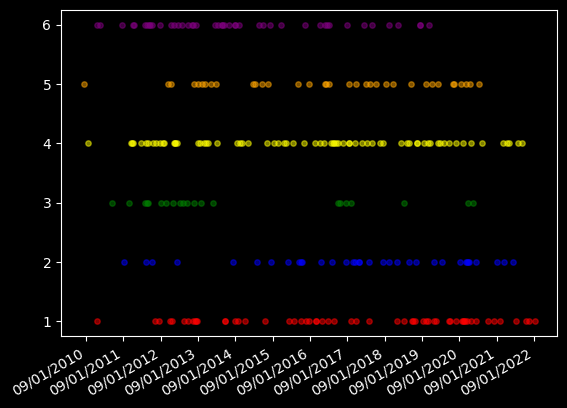

<Figure size 4000x2000 with 0 Axes>

In [11]:

dates_strings = df["date"].to_numpy()
dates = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in dates_strings]

topic_ids = df["topic_id"].to_numpy() + 1
topic1_ids = (topic_ids == 1)*1
topic1_ids = np.array([id if id != False else None for id in topic1_ids])
topic2_ids = (topic_ids == 2)*2
topic2_ids = np.array([id if id != False else None for id in topic2_ids])
topic3_ids = (topic_ids == 3)*3
topic3_ids = np.array([id if id != False else None for id in topic3_ids])
topic4_ids = (topic_ids == 4)*4
topic4_ids = np.array([id if id != False else None for id in topic4_ids])
topic5_ids = (topic_ids == 5)*5
topic5_ids = np.array([id if id != False else None for id in topic5_ids])
topic6_ids = (topic_ids == 6)*6
topic6_ids = np.array([id if id != False else None for id in topic6_ids])
# print(np.sum(topic1_ids)+np.sum(topic2_ids)+np.sum(topic3_ids)+np.sum(topic4_ids)+np.sum(topic5_ids)+np.sum(topic6_ids))

# print(topic1_ids)
# print(len(topic1_ids))
# print(len(topic3_ids))
# print(len(dates))

dot_size=15
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.scatter(dates,topic1_ids, color="red", label=topics_data[0]["Name"], s=dot_size, alpha=0.5)
plt.scatter(dates,topic2_ids, color="blue", label=topics_data[1]["Name"], s=dot_size, alpha=0.5)
plt.scatter(dates,topic3_ids, color="green", label=topics_data[2]["Name"], s=dot_size, alpha=0.5)
plt.scatter(dates,topic4_ids, color="yellow", label=topics_data[3]["Name"], s=dot_size, alpha=0.5)
plt.scatter(dates,topic5_ids, color="orange", label=topics_data[4]["Name"], s=dot_size, alpha=0.5)
plt.scatter(dates,topic6_ids, color="purple", label=topics_data[5]["Name"], s=dot_size, alpha=0.5)
# plt.set_xticks(x[::2])
# plt.set_xticklabels(x[::2], rotation=45)
# plt.xticks(np.arange(0, 300, 20.0))
plt.gcf().autofmt_xdate()
plt.figure(figsize = (40,20), facecolor = None)
plt.tight_layout()
plt.show()


# Text Summarization

### Summarize His Topics

Gather all the articles for each topic and summarize what he says.

In [12]:
print(df.columns)

# Get text for each topic
topic_ids = df['topic_id']
unique_topics = topic_ids.unique()
print(unique_topics)
topic_sumamry_map = {}

# topicid_word_tuples = lda_model.show_topics(num_topics=num_topics, num_words=12, formatted=False)
# important_words = []
# for topicid_word_tuple in topicid_word_tuples:
#     topic_words_probability_tuples = topicid_word_tuple[1]
#     for word, weight in topic_words_probability_tuples:
#         important_words.append(word)
    

import Summarizer_HuggingFace
import Summarizer

for id in unique_topics:
    topic_name = topics_data[id]["Name"]
    important_words = topics_data[id]["words_list"]
    print("Topic {} {} =======================================================".format(id, topic_name))
    include_df = df[df["topic_id"] == id]
    topic_text = include_df["raw_text_sentences"]
    topic_text_array = list(topic_text.to_numpy())
    topic_text_array = [t.replace("This is a new Mindf*ck Monthly newsletter", "").replace("This is a Mindf*ck Monthly newsletter", "").replace("Mindf*ck Monthly newsletter", "") for t in topic_text_array]
    
    print("Extractive Summaries of each article...")
    topic_text_array_extractive = [Summarizer.extractive_summarize(t, num_sentences=20) for t in topic_text_array]
    all_topic_text_extractive = " ".join(topic_text_array_extractive)
    
    print("Extractive Summary of All Articles:")
    summary = Summarizer.extractive_summarize(all_topic_text_extractive, num_sentences=5)
    print(summary)
    print()

    print("Abstractive Summary of All Articles:")
    summary = Summarizer_HuggingFace.abstractive_summarize(all_topic_text_extractive)
    print(summary)
    print()
    print()


Index(['url', 'date', 'filepath', 'text', 'tokens', 'raw_text',
       'raw_text_sentences', 'num_words', 'topic_id'],
      dtype='object')
[0 3 1 4 2 5]


/Users/michaelhammer/Documents/Coding_Projects/NLPMarkManson/venv/lib/python3.8/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/Users/michaelhammer/Documents/Coding_Projects/NLPMarkManson/venv/lib/python3.8/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


Topic 0 World Information - News, Social Media =======================================================
Extractive Summaries of each article...
Extractive Summary of All Articles:


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


We say “Go fuck yourself,” when we really mean “I like you,” and we say “I like you,” when we really mean “Go fuck yourself.”  . As time went on, the 80/20 Principle became a popular management tool that was used widely to increase efficiency and effectiveness within businesses and industries.2 When presented with new social situations, unlucky people talked to people they already knew or people who were most like themselves, whereas lucky people talked to a large array of people equally.  . The conventional answer, the answer you’ll find in most bookstores and at most seminars is some variation of “do more with less,” “practice time management,” or as Arnold Schwarzenegger once said, “sleep faster.”  . Instead of seeing “the” “cat” “was” “mad” separately, your mind will register “the cat was mad” as one single piece of information. Compared to “normal” people (as if “normal” even exists), people with mental illnesses have more chronic physical health problems,5 have difficulty forming

Token indices sequence length is longer than the specified maximum sequence length for this model (1036 > 1024). Running this sequence through the model will result in indexing errors


Pass 1 Complete - Now Summarizing 97 Batches
Pass 2 Complete - Now Summarizing 32 Batches
Pass 3 Complete - Now Summarizing 10 Batches
Pass 4 Complete - Now Summarizing 4 Batches
 Julian Zelizer says capitalism promotes a society where people constantly feel inadequate and inferior . John Sutter: Fiction allows us to practice empathy for others . John Ghitis: Mass shootings and terrorism are essentially just violent pacts . Ta-N. ish: The only way for human rights to persist is to accept that things don’t have to go their way 100% of the time . Share your top five iReport stories and videos of your favorite iReport moments of the day with iReport@dailymailonline.com . Back to the page you want to see the latest iReport on CNN.com Live Show Show us your top 5: Share photos and videos from our top-5-5, or click here for more iReport updates from our own top 5.com/Heroes and stories to CNN iReport.com and top-to-own photos of the previous 10/4/11/10/10 and 10/10 . Back at the bottom of th

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


Perhaps I should create simple lists for people: “7 Signs You’re Over-thinking Your Life,” or “5 Most Common Situations You Think Are Difficult, But Actually Aren’t” or “10 Reasons Why Your Mind Is Screwing Up Your Life,” or perhaps “6 Ways to Think About This Blog Post Too Much.”  . There’s no such thing as a “good” or “bad” emotion—there are only “good” and “bad” reactions to your emotions.  . For me, this looks like…  . 8 AM – Out of bed by this time  . 8 AM to 3 PM – Work hours  . Many people say, “I want to quit, just not yet,” or, “I want to quit, but my job is too stressful right now,” or “I want to quit, but I’m going to wait until I move into my new apartment.”  . But if your reasons are, “My parents would hate it,” or “My friends would make fun of me,” or “If I failed, I’d look like an idiot,” then chances are, you’re actually avoiding something you truly care about because caring about that thing is what scares the shit out of you, not what mom thinks or what Timmy next door

Token indices sequence length is longer than the specified maximum sequence length for this model (1100 > 1024). Running this sequence through the model will result in indexing errors


Pass 1 Complete - Now Summarizing 117 Batches
Pass 2 Complete - Now Summarizing 32 Batches
Pass 3 Complete - Now Summarizing 14 Batches
Pass 4 Complete - Now Summarizing 4 Batches
 John Sutter says people should love people for the messed up ways that they already are, not how you’d wish them to be . Wayne Dyer quit smoking: "The nicotine whispers, “You had a hard day at work, you deserve a cigarette" Mark O'Neill: We must learn the ability to stand independent of what we feel . LZ Granderson: Emotional issues never completely go away, and for some reason, we seem to have forgotten that that's OK . The ability to choose what to focus o. me is not only one of the most important skills for succeeding in the information age, but it's also an ability that appears to be dwindling among the population . Forgiveness increases feelings of happiness and decreases feelings of anger and grief . Andrew Weisler says if you lack motivation to make an important change in your life, then do something,

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


Super Beliefs can be benign (“Everything happens for a reason”), useful, (“All knowledge must be verified and tested to be believed”), benevolent (“The meaning of life is to ease the suffering of all living beings”), or just plain fucking mean (“Death to all non-believers!”).  . “What is an “I”, and why are such things found (at least so far) only in association with, as poet Russell Edson once wonderfully phrased it, “teetering bulbs of dread and dream” — that is, only in association with certain kinds of gooey lumps encased in hard protective shells mounted atop mobile pedestals that roam the world on pairs of slightly fuzzy, jointed stilts?”  . In our day-to-day lives, this whole idea of “fairness”—like life is “unfair” because the economy crashed right as my career was getting started, or life is “unfair” because my brother got accepted to Yale and I didn’t—it likely causes more problems than it solves.  . I’ve merged autonomy and competence under the umbrella of “self-control” and

Token indices sequence length is longer than the specified maximum sequence length for this model (1125 > 1024). Running this sequence through the model will result in indexing errors


Pass 1 Complete - Now Summarizing 63 Batches
Pass 2 Complete - Now Summarizing 16 Batches
Pass 3 Complete - Now Summarizing 5 Batches
Pass 4 Complete - Now Summarizing 2 Batches
 The Subtle Art is about to be published in the U.S. at the University of New York State University Press Conference on Thursday, October 4, at 8pm on CNN.com Live . Ray Kurzweil thinks we’ll have the ability to upload our brains into the cloud and “live” in a virtual world forever, long after our physical bodies are gone . More pictures are now taken every 2 minutes than were taken in the entire 19th century . Everything Is F*cked: A Book about Hope is a deep dive into how we find hope and meaning in the world . The School includes 6 new video courses each with a printable workbook, plus 3 bonus courses, e-books, and e-courses, with printable printables, and a free e-book . There are 3 bonus course, plus commentaries on all my books, plus


Topic 4 Pursuit of a Happy Life ======================================

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In our modern-day culture of make more, buy more, fuck more, be more, I’m guessing that some jackass on the internet telling you that “more” is not actually always “more” in life is sure to be drowned out pretty quickly with all the “life hacking” and “lifestyle optimization” podcasts and blog articles and When most people set out to change their lives, they often focus on all the external stuff, like a new job or a new location or new friends or a new romantic prospects and on and on.  . You have a “work self” and a “home self” and a “family self” and an “I’m all alone self” and many other “selves” that you use to navigate and survive a complex social world.  . Whereas positive self-help obsesses over “healing” old “wounds,” and “releasing” pent up emotions, Negative Self-Help gently reminds you that there’s no end to the pain in this shitstream called life, so you might as well get used to it.  . People ask me all the time, “How do I stop feeling so jealous?” or “How do I stop feelin

Token indices sequence length is longer than the specified maximum sequence length for this model (1037 > 1024). Running this sequence through the model will result in indexing errors


Pass 1 Complete - Now Summarizing 61 Batches
Pass 2 Complete - Now Summarizing 16 Batches
Pass 3 Complete - Now Summarizing 6 Batches
Pass 4 Complete - Now Summarizing 2 Batches
 John Sutter: The value of an education is awareness of the things we need to be aware of, and not knowledge, that they are hidden from us all over the world . David Gergen: The only way to resolve the paradox of choice is by committing to actions that multiply our freedoms . Aaron Miller: Goals are dangerous because the meaning they provide when you’re working towards them is the purpose that is  that is that is to create meaning . The Dalai Lama will give us the chance to change our own approach to improving lives . Share your story with us on  iReport ..uk.com/sportw.uk and iReport.uk . For more info, visit www.jenn.harrow@harrowcom/


Topic 2 Sex and Dating Women =======================================================
Extractive Summaries of each article...
Extractive Summary of All Articles:


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


But notice, the pyramid of specific goals is enveloped in a circle of more general, internal goals: “I want to have a healthy lifestyle,” “I want to have a positive body self-image,” and “I want more energy and stamina.”  . We create tests of whether other people are “true” and “pure” members of our group, and we either shame any “non-believers” into conformity or simply expel them from the tribe.  . Because the more your “Once in a Lifetime” experiences dominate your life, the less room you have for those daily, quotidian, “in between” experiences—the children’s birthday parties, the dinners with friends, the phone calls with mom—and it’s those unsexy, boring experiences that actually add up to be something more meaningful in the long run.  . And within three days, she  became “immature,” “entitled,” and “unappreciative.”  . More pragmatic approaches to teenage sexuality (i.e., “Hey, you’re going to do what you’re going to do, but here’s how to be responsible about it”) outperform str

Token indices sequence length is longer than the specified maximum sequence length for this model (1059 > 1024). Running this sequence through the model will result in indexing errors


Pass 1 Complete - Now Summarizing 36 Batches
Pass 2 Complete - Now Summarizing 8 Batches
Pass 3 Complete - Now Summarizing 2 Batches
 Porn can lead to sexual problems in a relationship, a deterioration of trust and safety, a perception of rejection as well as a fundamental change in how the women view their addicted partner, from “good” to “inherently bad” Guitarist John Petrucci says he was terrified of playing with other people as good or better than him in music school . David Gergen: "If your biggest value in the world is snorting Vicodin through a swirly straw, well, then feeling better is just going to make your life worse" Julian Zelizer says this generation’s tribal feminists’ trenches are that of The Feelings Police . Men are 10 times more likely than women to commit murder and nine times to end up in prison . The real value of money emerges when we leverage it as a tool towards our success rather than making it success itself, writes John Sutter, writes Sutter . The truth abo

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


The following words mean nothing: “go-getter,” “self-starter,” “born leader,” “team player,” “passionate,” “think outside the box,” “think on my feet,” “organizational skills,” “deep thinker,” “tough-minded” and on and on. “Destiny” is “destino,” “motive” is “motivo,” “part” is “parte” and so on.  . You could replace “famous” in that sentence with “rich,” “beautiful,” “popular,” “intelligent” or a myriad of other adjectives.  . Then, throughout your 20s, you “mature,” you “find yourself,” you “figure things out,” but you’re still young and you’re still certainly not feeling any effects of aging.  . In Russian, case endings always rhyme with one another, so if you are talking about a feminine noun (such as “Zhen-shee-na”), then you know that the adjectives and adverbs will usually rhyme with its ending (“krasee-vaya” as opposed to “krasee-vee”).  .

Abstractive Summary of All Articles:
['Back then, everything good the psychologists measured seemed to be related to having high self-estee

Token indices sequence length is longer than the specified maximum sequence length for this model (1054 > 1024). Running this sequence through the model will result in indexing errors


Pass 1 Complete - Now Summarizing 73 Batches
Pass 2 Complete - Now Summarizing 16 Batches
Pass 3 Complete - Now Summarizing 7 Batches
Pass 4 Complete - Now Summarizing 2 Batches
 A high degree of chemistry will mean intense, life-altering, heart-pounding sex that causes your mind to cosmically splatter itself on the walls of your consciousness . Avoidants exhibit positive self-images and negative perceptions of others (hence their arrogance and fear of commitment) Avoidants are so good at putting others off that oftentimes it’s only the anxious types who are willing to stick around and put in the extra effort to get them to open up . People with health people with health are also more likely to be happier than people with toxic self-esteem, says John Sutter . Getting married is an opportunity for you both to figure out what each other's needs are and learn how to get your needs met and meet the needs of the other person . For more information, visit www.dailymailonline.com/article-news

### Summarize Individual Articles

Pass in an article name and output a summary of it. 